In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import EMNIST
from torch.utils.data import DataLoader
# torch: PyTorch's main library for working with Tensor and numerical calculations.

# torch.nn: A module for building neural networks. Includes layers, activation functions, loss functions, etc.

# torch.optim: Includes optimization algorithms such as SGD, Adam, etc.

# torchvision.transforms: For applying changes (such as transforming to tensor, normalizing, etc.) to images before training.

# torchvision.datasets.EMNIST: A dataset of handwritten letters and numbers (Extended MNIST), suitable for recognizing letters of the alphabet.

# torch.utils.data.DataLoader: Used to load and manage data in batches

import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt
#numpy: For numerical calculations and working with arrays.

# tqdm.trange: Progress bar for loops. A special version of range that displays the progress of the loop while the code is running.

# matplotlib.pyplot: For drawing graphs and images.


# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
#This section checks if a graphics card (GPU) is available.

#If a GPU with CUDA is available, it uses "cuda".

#If you are on a Mac and using Apple Silicon processors (such as M1 or M2), it checks for mps (Metal Performance Shaders).

#If none are available, it uses "cpu".

# Goal: To perform calculations faster using the appropriate hardware.

print(f"Using {device} device")

Using cuda device


In [7]:
def plot_results(train_losses, train_accs, test_losses, test_accs):
  #This plot_results function you wrote is used to plot the training and testing error (Loss) and training and testing accuracy (Accuracy) over epochs
  # These plots help you see how well the model is learning and whether it is overfitting or underfitting.

  #This function takes 4 input arguments:

#train_losses: a list of training error values ​​per epoch

#train_accs: a list of training accuracy values ​​per epoch

#test_losses: a list of testing error values ​​per epoch

#test_accs: a list of testing accuracy per epoch


    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
#plt.subplots(1, 2) means one row and two columns of plots (two plots side by side).

#figsize=(15, 5) sets the overall size of the figure

    xs = np.arange(1, len(train_losses) + 1, 1)
 #The x-axis ranges from 1 to the number of epochs (for example, if you have 10 epochs, x would be 1 to 10).

    axes[0].plot(xs, train_losses, label='Train')
    axes[0].plot(xs, test_losses, label='Test')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_xticks(xs)
    axes[1].plot(xs, train_accs, label='Train')
    axes[1].plot(xs, test_accs, label='Test')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xticks(xs)
    plt.tight_layout()
    #tight_layout() adjusts the spacing between charts.
    plt.legend()
    plt.show()

In [8]:
# @title helper functions


def train_step(model, criterion, optimizer, dataloader, device=device):
    running_loss, correct = 0, 0
    # Move the model to training mode
    model.train()
    # Iterate over the dataloader
    for x, y in dataloader:
        # Move the datapoints to same device as the model
        x, y = x.to(device), y.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Predict the output and perform the forward pass
        pred = model(x)
        # Compute prediction error
        loss = criterion(pred, y)
        # Backpropagation
        loss.backward()
        # Update the model weights
        optimizer.step()
        # Update the running loss
        running_loss += loss.item()
        # Update the correctly predicted counter
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculate and return the average loss and accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)


def test_step(model, criterion, dataloader, device=device):
    running_loss, correct = 0, 0
    # Move the model to training mode
    model.eval()
    # Disable gradient calculation
    with torch.no_grad():
      # Iterate over the dataloader
      for x, y in dataloader:
          # Move the datapoints to same device as the model
          x, y = x.to(device), y.to(device)
          # Predict the output and perform the forward pass
          pred = model(x)
          # Update the running loss
          running_loss += criterion(pred, y).item()
          # Update the correctly predicted counter
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculate and return the average accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)


def train_model(model, n_epochs, optimizer, train_loader, test_loader, device=device):
    criterion = nn.CrossEntropyLoss()
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    for epoch in (pbar := trange(n_epochs)):
        # Train the model
        train_loss, train_acc = train_step(model, criterion, optimizer, train_loader, device)
        # Evaluate the model
        test_loss, test_acc = test_step(model, criterion, test_loader, device)
        # Display the results
        pbar.set_description(f'Train Loss = {train_loss:.3f} | Train Acc = {train_acc:.2f}% | Test Loss = {test_loss:.3f} | Test Acc = {test_acc:.2f}% ')
        # Store the results
        train_losses.append(train_loss), train_accs.append(train_acc), test_losses.append(test_loss), test_accs.append(test_acc)
    # Plot the results
    plot_results(train_losses, train_accs, test_losses, test_accs)
    return {'train_loss': train_losses, 'train_acc': train_accs, 'test_loss': test_losses, 'test_acc': test_accs}

In [9]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
#Using torchvision transforms, it performs preprocessing operations on the data:
#ToTensor():
#Converts black and white images (e.g. 28x28) to a Tensor between 0 and 1.
#Normalize((0.5,), (0.5,)):
#Normalizes with a mean of 0.5 and a standard deviation of 0.5 → pixel values ​​are moved from the range [0,1] to the range [-1,1].

train_dataset = EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
test_dataset = EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)
#Downloads the [EMNIST (Extended MNIST)] dataset.
#Uses balanced subset, which contains equal numbers of alphanumeric characters.
#train=True → training data, train=False → testing data
#transform=transform → apply preprocessing
#download=True → downloads the dataset file if it does not exist.


print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

classes = train_dataset.classes
print(f'Classes:\n{classes}')

100%|██████████| 562M/562M [00:02<00:00, 279MB/s]


Train dataset size: 112800
Test dataset size: 18800
Classes:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


In [10]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
#batch_size=64: This means that the data is fed to the model in batches of 64.
#shuffle=True: For training data, the order of the data is randomly shuffled each time so that the model learns better.
#shuffle=False: For testing data, we do not need to shuffle the order.

# Iterate over the data
for x, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
    #This loop only runs once (break after the first batch).

#x are images (features - inputs), y are labels (labels).

#Let's say batch_size=64:

# x.shape → torch.Size([64, 1, 28, 28])

#64 = number of images in this batch

#1 = because they are black and white, they only have one channel (channel = 1)

#28x28 = image size

# y.shape → torch.Size([64])

#64 labels for 64 images

#The data type of y.dtype is usually torch.int64 (for classification)

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


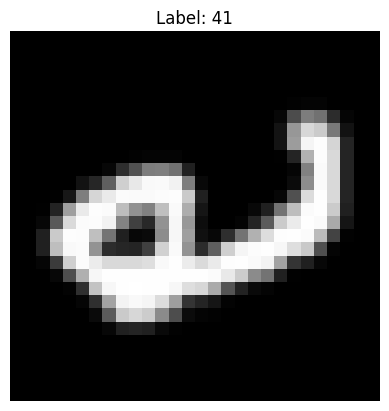

In [11]:
import matplotlib.pyplot as plt

plt.imshow(x[0][0], cmap='gray')
plt.title(f"Label: {y[0].item()}")
plt.axis('off')
plt.show()


In [12]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.network = nn.Sequential(nn.Flatten(), nn.Linear(input_size, 128),
                                     nn.ReLU(), nn.Linear(128, 128),
                                     nn.ReLU(), nn.Linear(128, 64),
                                     nn.ReLU(), nn.Linear(64, num_classes))

    def forward(self, x):
        return self.network(x)


 #input_size: Number of input features (784 for a 28x28 image).
#num_classes: Number of output classes (47 in EMNIST-balanced).
#super(...): Call the parent class for preparation.

#nn.Flatten(): Converts a 28x28 image into a 784-element vector.

#nn.Linear(...): Dense or Fully Connected layers.

#nn.ReLU(): ReLU nonlinear activation function that makes the network learn better.

Train Loss = 1.142 | Train Acc = 67.13% | Test Loss = 1.161 | Test Acc = 66.44% : 100%|██████████| 30/30 [13:19<00:00, 26.66s/it]


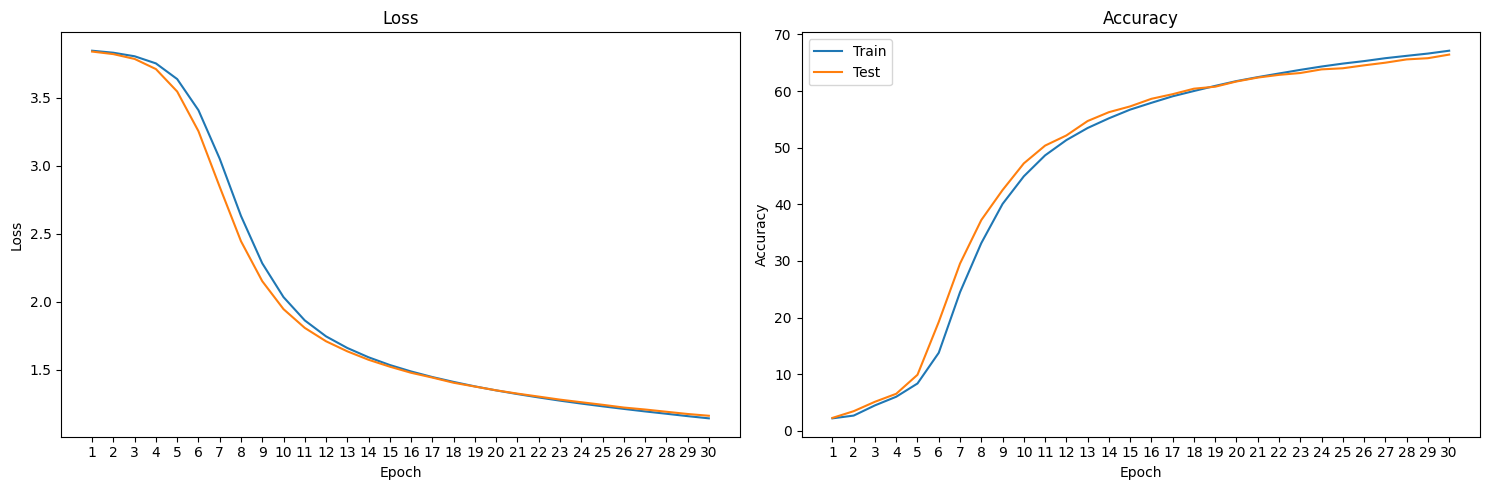

In [13]:
model = SimpleNN(input_size=28*28, num_classes=len(classes)).to(device)
#input_size=28*28: Since the images are 28x28, the model input must have 784 features (pixels).

#num_classes=len(classes): The number of classes is taken from the dataset itself (in EMNIST-balanced it is 47).

#to(device): Sends the model to the device you specified (CPU or GPU). If you set it to GPU, the model will be there too.

optimizer = optim.SGD(model.parameters(), lr=0.001)

results = train_model(model, 30, optimizer, train_loader, test_loader)

Train Loss = 0.364 | Train Acc = 86.52% | Test Loss = 0.570 | Test Acc = 82.62% : 100%|██████████| 20/20 [09:00<00:00, 27.05s/it]


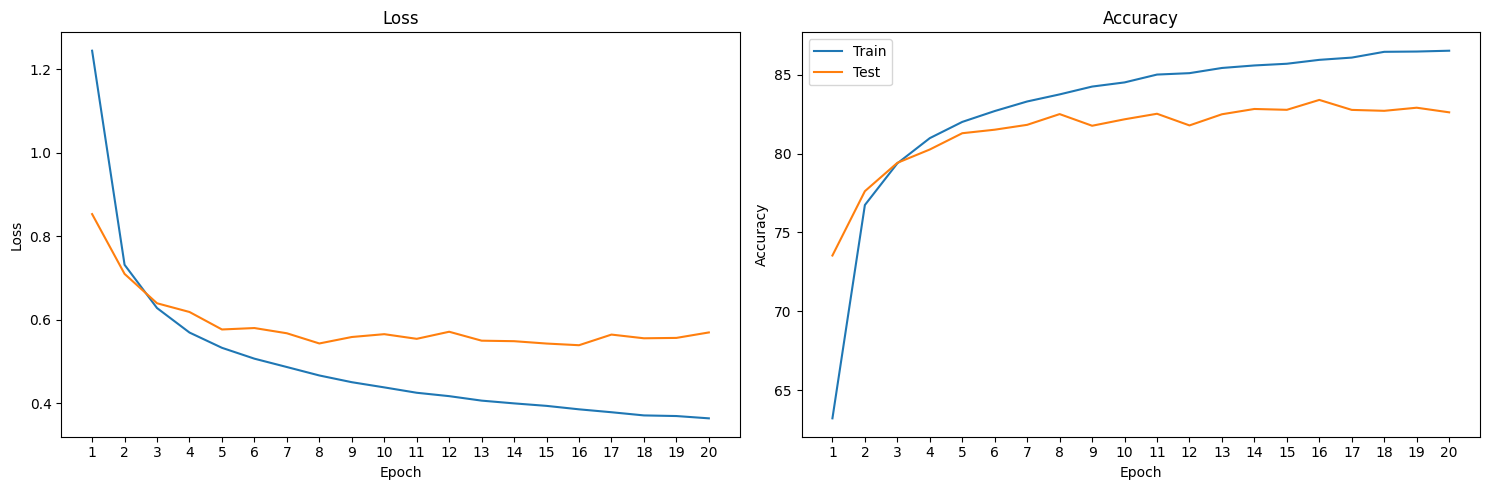

In [15]:
model = SimpleNN(input_size=28*28, num_classes=len(classes)).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

results = train_model(model, 20, optimizer, train_loader, test_loader)

In [16]:
class BiggerNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BiggerNN, self).__init__()
        self.network = nn.Sequential(nn.Flatten(), nn.Linear(input_size, 512),
                                     nn.ReLU(), nn.Linear(512, 512),
                                     nn.ReLU(), nn.Linear(512, 512),
                                     nn.ReLU(), nn.Linear(512, 256),
                                     nn.ReLU(), nn.Linear(256, 256),
                                     nn.ReLU(), nn.Linear(256, 256),
                                     nn.ReLU(), nn.Linear(256, 128),
                                     nn.ReLU(), nn.Linear(128, 128),
                                     nn.ReLU(), nn.Linear(128, 128),
                                     nn.ReLU(), nn.Linear(128, 64),
                                     nn.ReLU(), nn.Linear(64, 64),
                                     nn.ReLU(), nn.Linear(64, 64),
                                     nn.ReLU(), nn.Linear(64, num_classes))

    def forward(self, x):
        return self.network(x)
#This model is going to learn more complex relationships between image pixels and classes.

#More layers → model power increases (can learn complex things)

#But: the risk of overfitting also increases because the model has too much capacity

Train Loss = 0.515 | Train Acc = 83.85% | Test Loss = 0.627 | Test Acc = 81.98% : 100%|██████████| 20/20 [10:05<00:00, 30.29s/it]


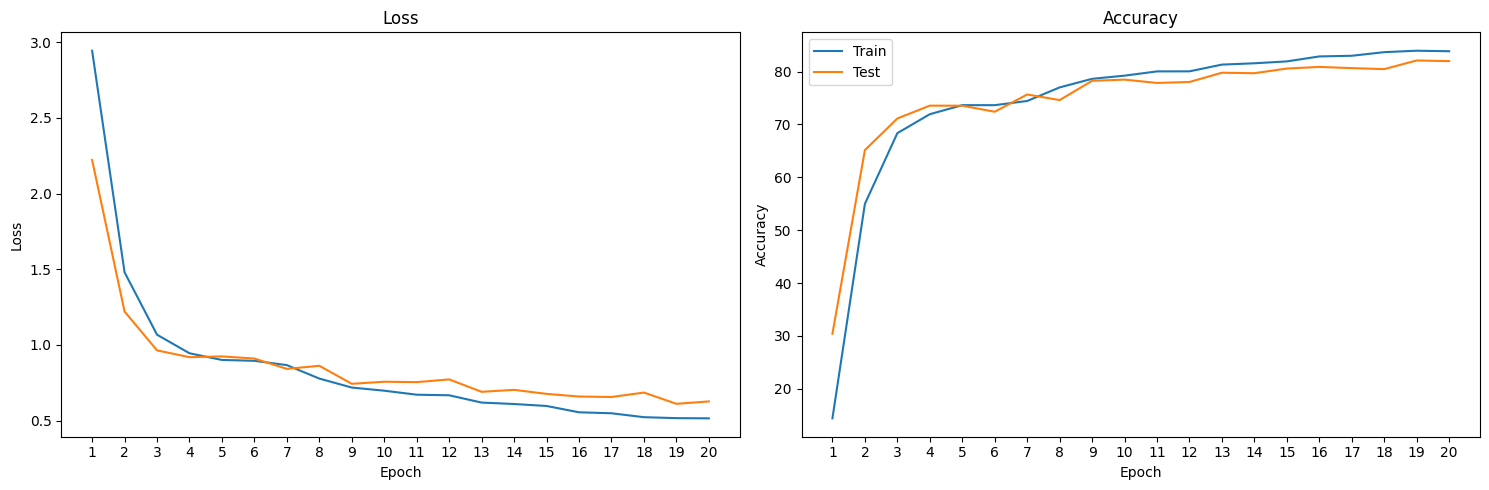

In [17]:
model = BiggerNN(input_size=28*28, num_classes=len(classes)).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

results = train_model(model, 20, optimizer, train_loader, test_loader)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BiggerBN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BiggerBN, self).__init__()
        self.network = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 512), nn.BatchNorm1d(512),
                                     nn.ReLU(), nn.Linear(512, 512), nn.BatchNorm1d(512),
                                     nn.ReLU(), nn.Linear(512, 512), nn.BatchNorm1d(512),
                                     nn.ReLU(), nn.Linear(512, 256), nn.BatchNorm1d(256),
                                     nn.ReLU(), nn.Linear(256, 256), nn.BatchNorm1d(256),
                                     nn.ReLU(), nn.Linear(256, 256), nn.BatchNorm1d(256),
                                     nn.ReLU(), nn.Linear(256, 128), nn.BatchNorm1d(128),
                                     nn.ReLU(), nn.Linear(128, 128), nn.BatchNorm1d(128),
                                     nn.ReLU(), nn.Linear(128, 128), nn.BatchNorm1d(128),
                                     nn.ReLU(), nn.Linear(128, 128), nn.BatchNorm1d(128),
                                     nn.ReLU(), nn.Linear(128, 64), nn.BatchNorm1d(64),
                                     nn.ReLU(), nn.Linear(64, 64), nn.BatchNorm1d(64),
                                     nn.ReLU(), nn.Linear(64, 64), nn.BatchNorm1d(64),
                                     nn.ReLU(), nn.Linear(64, num_classes))

    def forward(self, x):
        return self.network(x)

#Why is it useful to use BatchNorm1d?
#Stabilize the training process: By normalizing the output of each layer, the model learns more easily and faster.
#Increase accuracy: Often increases accuracy on test data.
#Resistance to Overfitting: Because it creates a type of regularization.
#Allows the use of higher learning rates without gradient explosion.

Train Loss = 0.271 | Train Acc = 89.76% | Test Loss = 0.414 | Test Acc = 86.70% : 100%|██████████| 20/20 [11:36<00:00, 34.81s/it]


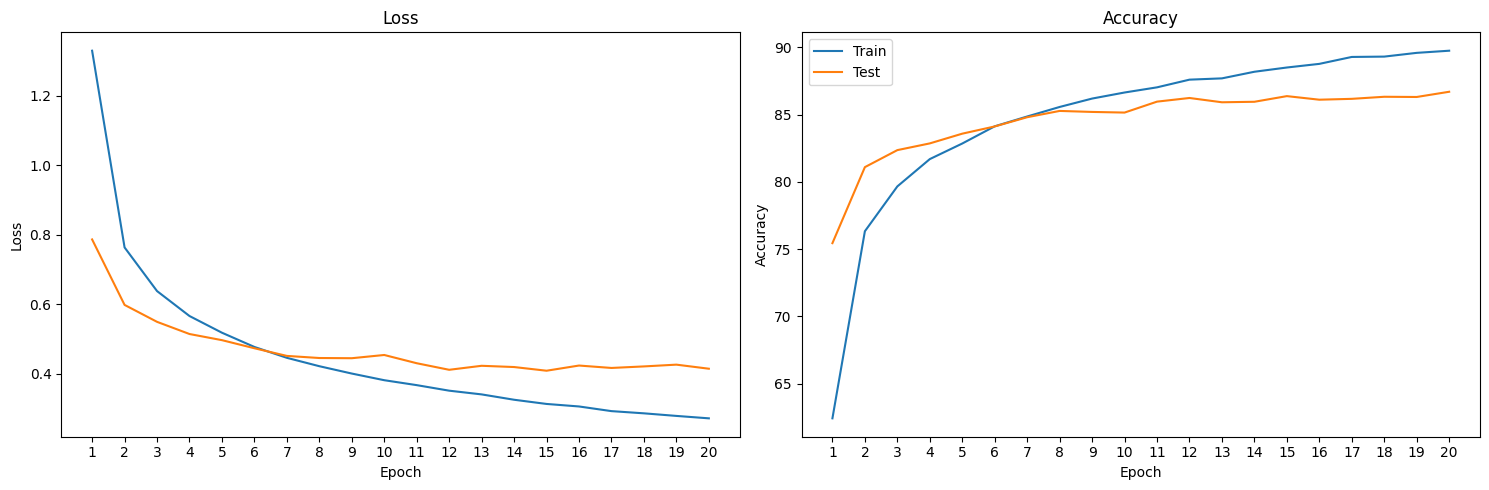

In [19]:
model = BiggerBN(input_size=28*28, num_classes=len(classes)).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

results = train_model(model, 20, optimizer, train_loader, test_loader)

In [20]:
class BiggerDO(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BiggerDO, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(), nn.Linear(28*28, 512), nn.BatchNorm1d(512),
            nn.ReLU(), nn.Dropout(0.20), nn.Linear(512, 512), nn.BatchNorm1d(512),
            nn.ReLU(), nn.Dropout(0.20), nn.Linear(512, 512), nn.BatchNorm1d(512),
            nn.ReLU(), nn.Dropout(0.20), nn.Linear(512, 256), nn.BatchNorm1d(256),
            nn.ReLU(), nn.Dropout(0.15), nn.Linear(256, 256), nn.BatchNorm1d(256),
            nn.ReLU(), nn.Dropout(0.15), nn.Linear(256, 256), nn.BatchNorm1d(256),
            nn.ReLU(), nn.Dropout(0.15), nn.Linear(256, 128), nn.BatchNorm1d(128),
            nn.ReLU(), nn.Dropout(0.10), nn.Linear(128, 128), nn.BatchNorm1d(128),
            nn.ReLU(), nn.Dropout(0.10), nn.Linear(128, 128), nn.BatchNorm1d(128),
            nn.ReLU(), nn.Dropout(0.10), nn.Linear(128, 64), nn.BatchNorm1d(64),
            nn.ReLU(), nn.Dropout(0.05), nn.Linear(64, 64), nn.BatchNorm1d(64),
            nn.ReLU(), nn.Dropout(0.05), nn.Linear(64, 64), nn.BatchNorm1d(64),
            nn.ReLU(), nn.Dropout(0.05), nn.Linear(64, num_classes))

    def forward(self, x):
        return self.network(x)

Train Loss = 0.475 | Train Acc = 84.46% | Test Loss = 0.420 | Test Acc = 86.22% : 100%|██████████| 20/20 [11:44<00:00, 35.24s/it]


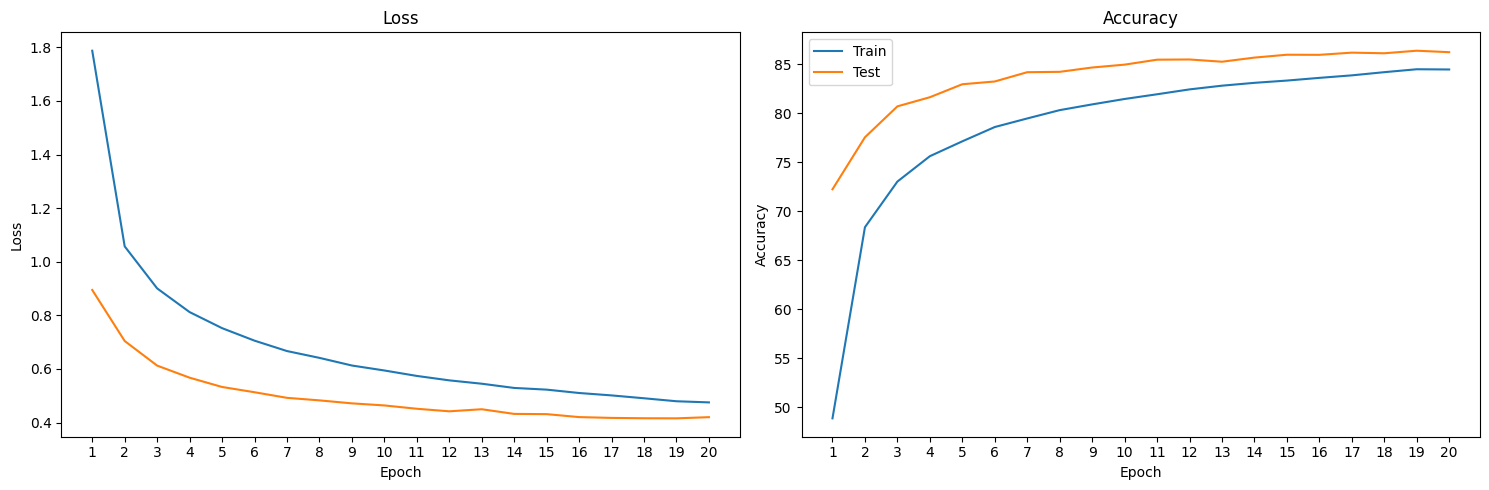

In [21]:
model = BiggerDO(input_size=28*28, num_classes=len(classes)).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

results = train_model(model, 20, optimizer, train_loader, test_loader)

Train Loss = 0.371 | Train Acc = 87.26% | Test Loss = 0.381 | Test Acc = 87.24% : 100%|██████████| 10/10 [05:55<00:00, 35.58s/it]


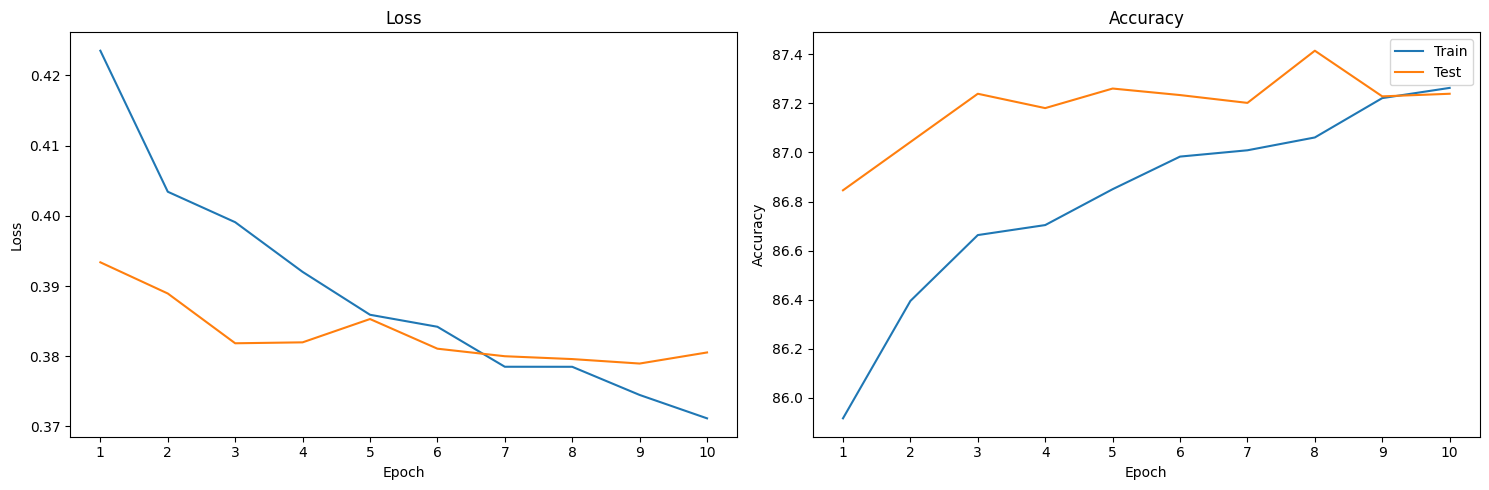

In [22]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

results = train_model(model, 10, optimizer, train_loader, test_loader)